In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

C:\Users\golan\PycharmProjects\PythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
DATSET_NAME = "line_data"

X_TRAIN_DIR = f"{DATSET_NAME}/Train"
Y_TRAIN_DIR = f"{DATSET_NAME}/Trainannot"

X_VALID_DIR = f"{DATSET_NAME}/Valid"
Y_VALID_DIR = f"{DATSET_NAME}/Validannot"

X_TEST_DIR = f"{DATSET_NAME}/Valid"
Y_TEST_DIR = f"{DATSET_NAME}/Validannot"

LABEL_COLORS_FILE = f"{DATSET_NAME}/label_colors.txt"


CLASSES = [
    "background",
    "line"
]
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 40
BATCH_SIZE = 16

INIT_LR = 0.005
LR_DECREASE_STEP = 10
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

In [4]:
def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    """ Осуществляет перевод трехканальной маски (число каналов сколько классов) в трехканальное
    изображение где будет расцветка как зададим в словаре colors_imshow для классов """

    colors_imshow = {
            "background": np.array([0, 0, 0]),        # чёрный фон
            "line": np.array([255, 255, 0])           # жёлтая линия
}

    sc_mask = np.zeros((mc_mask[0].shape[0], mc_mask[0].shape[1], 3), dtype=np.uint8)
    square_ratios = {}

    for i, singlechannel_mask in enumerate(mc_mask):

        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()

        # Заодно осуществляет подсчет процента каждого класса (сумма пикселей на общее число)
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size

        sc_mask += np.multiply.outer(singlechannel_mask > 0, colors_imshow[cls]).astype(np.uint8)


    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    return sc_mask, title


def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    """ Реализация демонстрации маски и самого изображения """
    # размер маски: H, W, CHANNEL
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].axis("off")  # убираем оси и сетку

    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichennel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)
    axes[1].axis("off")  # убираем оси и сетку

    plt.tight_layout()
    plt.show()

In [5]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = glob(f"{images_dir}/*")
        self.masks_paths = glob(f"{masks_dir}/*")

        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k == "line":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            elif k=="background":
                cls_colors_ordered[k] = np.array([255, 255, 255], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

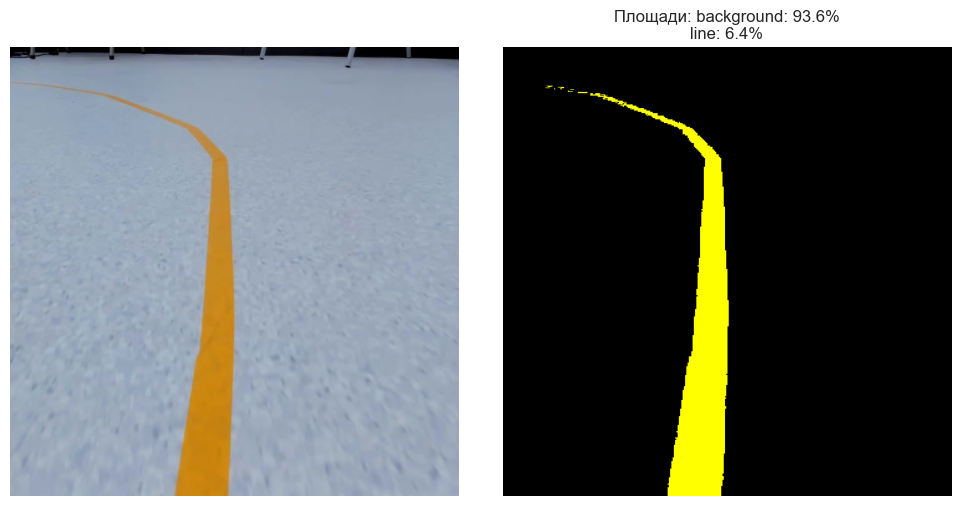

In [6]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
visualize_multichennel_mask(image, mask)

In [7]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.LongestMaxSize(max_size=INFER_HEIGHT),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.Blur(blur_limit=[3, 7], p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.GaussNoise(std_range=(0, 1), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации цвета
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    # Осуществит стартовую нормализацию данных согласно своим значениям или готовым для imagenet
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

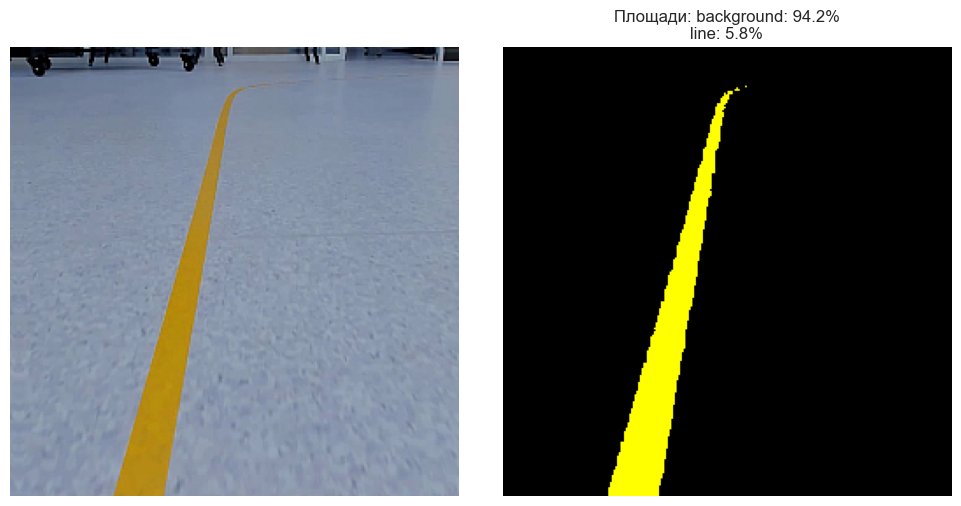

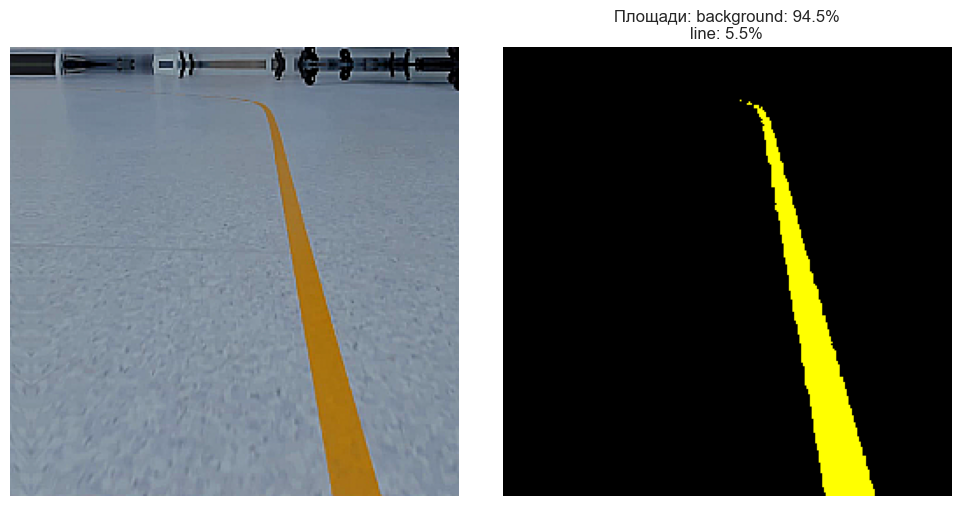

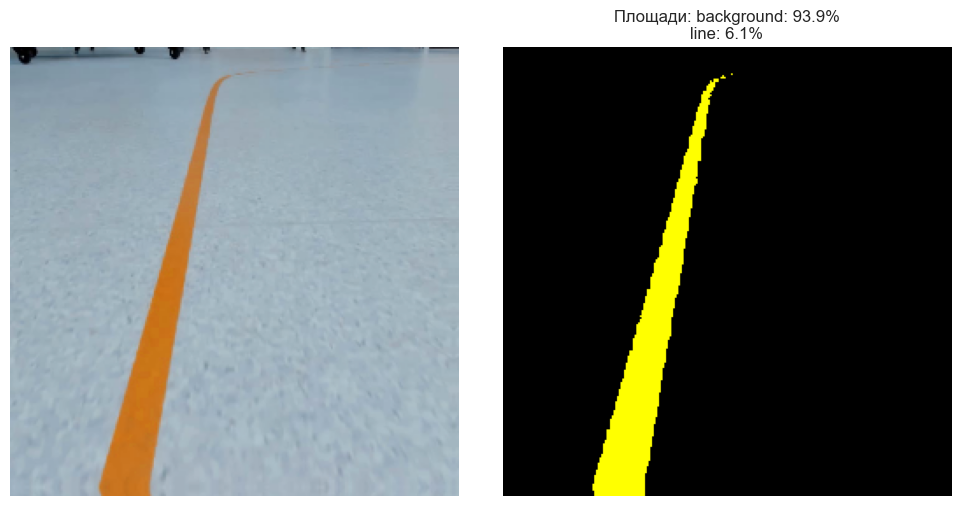

In [8]:
augmented_dataset = Dataset(
    X_TRAIN_DIR,
    Y_TRAIN_DIR,
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

for i in range(3):
    image, mask = augmented_dataset[indx]
    visualize_multichennel_mask(image, mask)

In [9]:
# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

In [10]:

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
train_dataset = Dataset(
    X_TRAIN_DIR,
    Y_TRAIN_DIR,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_VALID_DIR,
    Y_VALID_DIR,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [12]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.AdamW([
    dict(params=model.parameters(), lr=INIT_LR),
])

In [13]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [14]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}

for epoch in range(EPOCHS):
    print(f"\nEpoch: {epoch}")

    # === Тренировка ===
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_iou = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_iou)

    # === Валидация ===
    valid_logs = valid_epoch.run(valid_loader)
    val_loss = valid_logs.get("loss")
    val_iou = valid_logs.get("iou_score")
    val_metric = valid_logs.get("acc", None)  # если 'acc' нет — будет None
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_iou)

    # === Сохранение модели, если улучшился результат ===
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        torch.save(model, "models/best_model_new.pth")

        # Трассировка и сохранение JIT-модели
        trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH).to(DEVICE)
        traced_model = torch.jit.trace(model, trace_image)
        torch.jit.save(traced_model, "models/best_model_new.pt")

        print("✅ Model saved!")

    # === Вывод текущего learning rate ===
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"LR: {current_lr:.6f}")

    # === Понижение learning rate ===
    if epoch > 0 and epoch % LR_DECREASE_STEP == 0:
        print("📉 Decrease decoder learning rate")
        optimizer.param_groups[0]["lr"] /= LR_DECREASE_COEF



Epoch: 0
valid: 100%|██████████| 217/217 [00:21<00:00,  9.91it/s, dice_loss - 0.006925, fscore - 0.9939, iou_score - 0.9879]
✅ Model saved!
LR: 0.005000

Epoch: 1
valid: 100%|██████████| 217/217 [00:14<00:00, 14.85it/s, dice_loss - 0.005398, fscore - 0.9951, iou_score - 0.9903]
✅ Model saved!
LR: 0.005000

Epoch: 2
valid: 100%|██████████| 217/217 [00:13<00:00, 15.90it/s, dice_loss - 0.005032, fscore - 0.9954, iou_score - 0.9909]
✅ Model saved!
LR: 0.005000

Epoch: 3
valid: 100%|██████████| 217/217 [00:13<00:00, 16.48it/s, dice_loss - 0.005225, fscore - 0.9952, iou_score - 0.9905]
LR: 0.005000

Epoch: 4
valid: 100%|██████████| 217/217 [00:13<00:00, 16.43it/s, dice_loss - 0.004348, fscore - 0.996, iou_score - 0.992]  
✅ Model saved!
LR: 0.005000

Epoch: 5
valid: 100%|██████████| 217/217 [00:13<00:00, 16.34it/s, dice_loss - 0.01025, fscore - 0.9901, iou_score - 0.9806] 
LR: 0.005000

Epoch: 6
valid: 100%|██████████| 217/217 [00:16<00:00, 12.94it/s, dice_loss - 0.003386, fscore - 0.9969, 

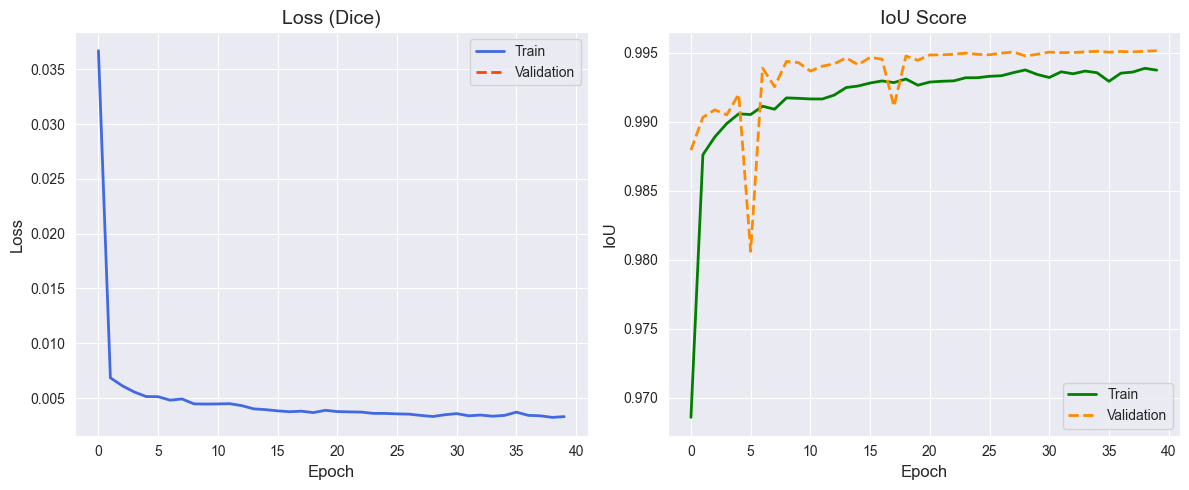

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === График потерь ===
axes[0].plot(loss_logs["train"], label="Train", color="royalblue", linewidth=2)
axes[0].plot(loss_logs["val"], label="Validation", color="orangered", linewidth=2, linestyle="--")
axes[0].set_title("Loss (Dice)", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].grid(True)
axes[0].legend()

# === График метрики IoU ===
axes[1].plot(metric_logs["train"], label="Train", color="green", linewidth=2)
axes[1].plot(metric_logs["val"], label="Validation", color="darkorange", linewidth=2, linestyle="--")
axes[1].set_title("IoU Score", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("IoU", fontsize=12)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()